## Notebook Objective:
- This notebook contains details of Document Classification analysis and model building of Donut which is based on Vision Encoder Decoder
- Here you will get sample analysis and implementation technique of Donut model on RVL_CDIP medium dataset for Document Image Classification without OCR dependencies
- Dataset contains 16 different sub dirs for train and test/valid. Each sub dir contains 600 images for training and 100 images for test/valid.

In [ ]:
!pip install -q transformers
!pip install -q datasets
!pip install transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.4 MB/s eta 0:00:00


In [ ]:
!pip install huggingface_hub

## Importing Necessary Libs:

In [ ]:
import numpy as np
import pandas as pd
import os
import json
import datasets
from datasets import Dataset, DatasetDict, load_dataset, ClassLabel, Features
import json
import re
import random
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
plt.style.use("dark_background")
from typing import Any, List, Tuple

from PIL import Image
import torch
print("CUDA available:", torch.cuda.is_available())
import transformers
from transformers import DonutProcessor, VisionEncoderDecoderConfig, VisionEncoderDecoderModel, BartConfig
from torch.utils.data import DataLoader
from torch.nn import CrossEntropyLoss
from transformers import AdamW
from torch.optim import Adam
from tqdm.auto import tqdm
from torch.nn.utils.rnn import pad_sequence

CUDA available: True


## S-1: Loading the Dataset from Huggingface Hub

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-c

In [ ]:
## Reload the train and valid dataset dict
processed_dataset = load_dataset("indra-inc/rvl_cdip_train600_valid100_ground_truth", batch_size=1000)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/9600 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [ ]:
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['Image_id', 'Image_raw', 'ground_truth'],
        num_rows: 9600
    })
    valid: Dataset({
        features: ['Image_id', 'Image_raw', 'ground_truth'],
        num_rows: 1600
    })
})

In [ ]:
processed_dataset['train'].features

{'Image_id': ClassLabel(names=['advertisement', 'budget', 'email', 'file_folder', 'form', 'handwritten', 'invoice', 'letter', 'memo', 'news_article', 'presentation', 'questionnaire', 'resume', 'scientific_publication', 'scientific_report', 'specification'], id=None),
 'Image_raw': Image(decode=True, id=None),
 'ground_truth': Value(dtype='string', id=None)}

In [ ]:
## Creating id2label dictionary
id2label_dict = {id: label for id, label in enumerate(processed_dataset['train'].features['Image_id'].names)}
id2label_dict

{0: 'advertisement',
 1: 'budget',
 2: 'email',
 3: 'file_folder',
 4: 'form',
 5: 'handwritten',
 6: 'invoice',
 7: 'letter',
 8: 'memo',
 9: 'news_article',
 10: 'presentation',
 11: 'questionnaire',
 12: 'resume',
 13: 'scientific_publication',
 14: 'scientific_report',
 15: 'specification'}

## S-2: Model Checkpoint, Config creation and updation

In [ ]:
# model_checkpoint = "naver-clova-ix/donut-base"
model_checkpoint = "naver-clova-ix/donut-base-finetuned-rvlcdip"

max_length = 16       ## as this is only document classification task, so there will not be massive generation task
image_size = [1280, 960]

config = VisionEncoderDecoderConfig.from_pretrained(model_checkpoint)
config.encoder.image_size = image_size # (height, width)
# update max_length of the decoder (for generation)
config.decoder.max_length = max_length

processor = DonutProcessor.from_pretrained(model_checkpoint)
model = VisionEncoderDecoderModel.from_pretrained(model_checkpoint, config=config)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


In [ ]:
processor.image_processor.size = image_size[::-1] # should be (width, height)
processor.image_processor.do_align_long_axis = False      ## no rotation

## S-3: Adding class names as additional tokens to increase model performance and full generation task

In [ ]:
len(processor.tokenizer)    ## checking tokenizer length before adding class token

57525

In [ ]:

# list with the newly added tokens. The purpose of this list is to keep track of the tokens that were added to the tokenizer.
def added_tokens(list_of_tokens: List[str]):
  """
  Add tokens to tokenizer and resize the token embeddings
  """
  newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
  if newly_added_num > 0:
    model.decoder.resize_token_embeddings(len(processor.tokenizer))


additional_tokens = ["<advertisement/>","<budget/>","<email/>","<file_folder/>","<form/>","<handwritten/>","<invoice/>","<letter/>","<memo/>","<news_article/>",
                     "<presentation/>","<questionnaire/>","<resume/>","<scientific_publication/>","<scientific_report/>","<specification/>"]

added_tokens(additional_tokens)

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 57541. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [ ]:
processor.tokenizer.convert_tokens_to_ids(["<file_folder/>"])     ## sample check whether token converted properly or not

[57528]

In [ ]:
len(processor.tokenizer)        ## tokenizer length after adding additional token

57541

In [ ]:
processor.tokenizer.cls_token

'<s>'

In [ ]:
processor.tokenizer.eos_token

'</s>'

## S-4: Create Donut Dataset Class , also by converting huggingface dataset to PyTorch dataset

In [ ]:
from torch.utils.data import Dataset    # PyTorch Dataset Class

In [ ]:
## Final Class by combining altogether

## DonutDataset class inherits from the torch.utils.data.Dataset class and overrides its methods

class DonutDataset(Dataset):
  """
  Args:
      dataset_name_or_path: name of dataset (available at huggingface.co/datasets) or the path containing image files and metadata.jsonl
      max_length: the max number of tokens for the target sequences
      split: whether to load "train", "validation" or "test" split
      ignore_id: ignore_index for torch.nn.CrossEntropyLoss
      prompt_start_token: the special token at the start of the sequences
      prompt_end_token: the special token at the end of the sequences
      sort_json_key: whether or not to sort the JSON keys
  """

  def __init__(
    self,
    dataset_name_or_path: str,    # Name of the dataset or the path containing huggingface datset
    max_length: int,              # the maximum number of tokens for the target sequences/prompt
    split: str = None,
    ignore_id: int = -100,        # ignore_index for torch.nn.CrossEntropyLoss
    prompt_start_token: str = None,   # The special token at the start of the propmpt sequences
    sort_json_key: bool = True,       # Whether or not to sort the JSON keys
):
    super().__init__()

    ## Variable Declaration

    self.max_length = max_length
    self.split = split
    self.ignore_id = ignore_id
    self.prompt_start_token = prompt_start_token
    # self.prompt_end_token = prompt_end_token
    self.sort_json_key = sort_json_key

    self.dataset = dataset_name_or_path
    self.dataset_length = len(self.dataset)   # The length of the dataset is stored

    self.gt_prompt_sequences = []    # operation for every single row  *** Note: same as hf_examples['gt_prompt'] which we did for single custom function case

    ## S-1: Iterate over all rows of the dataset and creating gt_prompt from gt_parses

    for sample in self.dataset:   # each sample is a dictionary

      ground_truth_jsob_obj = json.loads(sample["ground_truth"])   # convert a string representation of ground_truth a JSON object
      if "gt_parses" in ground_truth_jsob_obj:  # when multiple ground truths are available, e.g., docvqa
        assert isinstance(ground_truth_jsob_obj["gt_parses"], list)
        gt_jsons_list = ground_truth_jsob_obj["gt_parses"]    ## Stores the list of gt_parses value as gt_parses is the only key
      else:
        assert "gt_parse" in ground_truth_jsob_obj and isinstance(ground_truth_jsob_obj["gt_parse"], dict)
        gt_jsons_list = [ground_truth_jsob_obj["gt_parse"]]


      ## Appending the prompt using list comprehension with adding cls_token before and eos_token at the end
      self.gt_prompt_sequences.append(
          [
            # processor.tokenizer.cls_token +
            # self.prompt_start_token +     #** imp for doc classification
            self.json2token(
                gt_json,
                # update_special_tokens_for_json_key=self.split == "train",
                sort_json_key=self.sort_json_key,
              )
            + processor.tokenizer.eos_token

            for gt_json in gt_jsons_list  # iterate over every dictionary json from the gt_jsons list
          ]
        )

    self.added_tokens([self.prompt_start_token])
    self.prompt_start_token_id = processor.tokenizer.convert_tokens_to_ids(self.prompt_start_token)

  ## S-2: Function converts an ordered JSON object into a token sequence
  def json2token(self, json_obj: Any,  sort_json_key: bool = True):
    """
    Convert an ordered JSON object into a token sequence
    """
    if type(json_obj) == dict:
      if len(json_obj) == 1 and "text_sequence" in json_obj:
        return json_obj["text_sequence"]
      else:
        output = ""
        if sort_json_key:
          keys = sorted(json_obj.keys(), reverse=True)
        else:
          keys = json_obj.keys()

        for k in keys:
          # if update_special_tokens_for_json_key:
          self.added_tokens([fr"<s_{k}>", fr"</s_{k}>"])
          output += (
              fr"<s_{k}>"
              + self.json2token(json_obj[k], sort_json_key)
              + fr"</s_{k}>"
          )
        return output

    elif type(json_obj) == list:
      return r"<sep/>".join([self.json2token(item, sort_json_key) for item in json_obj])

    else:
      json_obj = str(json_obj)
      if f"<{json_obj}/>" in additional_tokens:   ## ** very important for doc classification
        json_obj = f"<{json_obj}/>"  # for categorical special tokens
      return json_obj

  ## S-3: Custom function to add new starting and ending prompt tokens and embed it
  def added_tokens(self, list_of_tokens: List[str]):
    """
    Add special tokens to tokenizer and resize the token embeddings of the decoder
    """
    newly_added_num = processor.tokenizer.add_tokens(list_of_tokens)
    if newly_added_num > 0:
      model.decoder.resize_token_embeddings(len(processor.tokenizer))

  ## S-4: Aligns the dataset length with the valid indices
  def __len__(self) -> int:
    return self.dataset_length

  ## S-5: special method that allows objects to support indexing and accessing their elements using square bracket notation ([]).
  # It is invoked when you use square brackets to access an element of an object, like obj[key]
  def __getitem__(self, indx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Load image from image_path of given dataset_path and convert into input pixel value tensor
    Convert ground truth data into input_ids (tokenized string) which is nothing but decoder input ids
    Create clone tensor of decoder input ids for masking and model understanding task
    Returns:
        input_tensor : preprocessed image
        input_ids : tokenized gt_data
        labels : masked labels (model doesn't need to predict prompt and pad token)
    """
    sample = self.dataset[indx]

    # S-5.1: create input_tensor from image i.e pixel values
    try:

      pixel_values = processor(sample["Image_raw"].convert("RGB"), return_tensors="pt").pixel_values
      # torch.Size([1, 3, 2560, 1920]) shape before squeeze
      input_tensor_pixel = pixel_values.squeeze()

    except Exception as e:
      print(sample)
      print(f"Error: {e}")
      return {}

    # S-5.2: tokenize document and creating decoder input ids

    processed_gt_prompt = random.choice(self.gt_prompt_sequences[indx])
    decoder_input_ids = processor.tokenizer(
        processed_gt_prompt,
        add_special_tokens=False,
        max_length=self.max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt",
    )["input_ids"].squeeze(0)   #torch.Size([1, 128]) before squeeze

    # S-5.3: Create labels which is clone tensor for extracted values from decoder input ids tensors

    # if self.split == "train":
    if (self.split == "train"):

      labels = decoder_input_ids.clone()    ## clone tensor of decoder input ids

      # prompt_start_token_id_index = (labels == self.prompt_start_token_id).nonzero

      labels[
          labels == processor.tokenizer.pad_token_id
      ] = self.ignore_id

      # labels[
      #     : prompt_start_token_id_index().squeeze() + 1
      # ] = self.ignore_id

      return input_tensor_pixel, labels

    else:
      return input_tensor_pixel, processed_gt_prompt


In [ ]:
# prompt_start_token = "<s_docClass>"
# prompt_end_token = "</s_docClass>"

train_dataset = DonutDataset(processed_dataset['train'], max_length=max_length,split="train",
                            prompt_start_token="<s_docClass>",
                            sort_json_key=False,
                             )

valid_dataset = DonutDataset(processed_dataset['valid'], max_length=max_length,split="valid",
                            prompt_start_token="<s_docClass>",
                            sort_json_key=False,
                             )

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 57543. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 57544. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


In [ ]:
train_dataset

In [ ]:
train_dataset[0]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 tensor([57541, 57537, 57542,     2,  -100,  -100,  -100,  -100,  -100,  -100,
   

In [ ]:
valid_dataset[8]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],
 
         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]]),
 '<s_class><memo/></s_class></s>')

## S-5: Creating PyTorch DataLoader from HF

In [ ]:
from torch.utils.data import DataLoader   # Convert Dataset into PyTorch Dataloader

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)    # Shuffling dataset for Model Training
valid_dataloader = DataLoader(valid_dataset, batch_size=2)

In [ ]:
batch = next(iter(train_dataloader))
pixel_values, labels = batch
print(pixel_values.shape)
print(labels.shape)

torch.Size([2, 3, 1280, 960])
torch.Size([2, 16])


In [ ]:
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.decoder_start_token_id = processor.tokenizer.convert_tokens_to_ids(["<s_docClass>"])[0]
## Note:
# Setting the decoder start token ID in the model's configuration to the ID of the <s_docClass> token in the tokenizer.
# This token is used to indicate the start of the target sequence during decoding.

# sanity check
print("Pad token ID:", processor.decode([model.config.pad_token_id]))
print("Decoder start token ID:", processor.decode([model.config.decoder_start_token_id]))

Pad token ID: <pad>
Decoder start token ID: <s_docClass>


## S-6: Model Training and Evaluation

In [ ]:
## Finding Training Accuracy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model = model.to(device)

# Set the optimizer
optimizer = Adam(model.parameters(), lr=0.0001)

# Set the number of training epochs
num_epochs = 5    # set number of epoch as per GPU availability

## Set up empty list to keep track of model progress
epoch_count = []
train_losses = []

for epoch in range(num_epochs):

  # Training loop
  model.train()

  print(f"Epoch {epoch + 1}/{num_epochs}")

  total_train_loss = 0.0    # Total loss across all batches in an epoch
  total_correct = 0   # Total correct across all batches in an epoch
  total_samples = 0   # Effective when batch_size is more than 1
  total_samples_mask_level  = 0 # Total number of non-padding and ignored tokens

  # Iterate over the training dataset
  for pixel_values, labels in tqdm(train_dataloader):

    pixel_values = pixel_values.to(device)
    # print(pixel_values.shape)
    labels = labels.to(device)
    # print(labels.shape)

    ## Finding outputs prediction
    outputs = model(pixel_values=pixel_values, labels=labels)
    # print(outputs['loss'].shape, outputs['logits'].shape, outputs['encoder_last_hidden_state'].shape)

    ## Compute  the Loss
    loss = outputs.loss
    total_train_loss += loss.item()

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


    # Compute the Accuracy (3-Ways)
    ## Pro-2
    total_samples += labels.size(0)   # # labels.size(0) = 1

    ## Pro-3 Mask level
    # Create a mask to exclude padding tokens & ignored tokens from accuracy calculation
    mask = (labels != -100)
    # Update the total number of non-padding tokens
    total_samples_mask_level += mask.sum().item()

    # Finding logits value
    logits = outputs.logits
    predictions = logits.argmax(dim=-1) # index value of maximum score for each token
    correct = (predictions == labels).sum().item()    ## Number of correct in each row
    total_correct += correct    # Cumulative correct then lastly total correct prediction from each epoch

  ## Average Loss Calculation
  avg_epoch_train_loss_batch_level = total_train_loss / len(train_dataloader)   # average loss per batch i.e. normalize the loss value

  # Append the training losses and epoch count for plotting
  train_losses.append(avg_epoch_train_loss_batch_level)
  epoch_count.append(epoch)

  avg_epoch_accuracy_mask_level = (total_correct / total_samples_mask_level) * 100
  # average per epoch accuracy at based on mask or non padding tokens

  # If batch_size = 1 , so we can use anything len(train_dataloader_sub) or  len(train_dataset)

  print(f"Training Loss Batch Level: {avg_epoch_train_loss_batch_level:.4f} :::: Training Accuracy Mask Level: {avg_epoch_accuracy_mask_level:.3f}%")
  print('*****************************************************************************************************************************')


Epoch 1/5


  0%|          | 0/4800 [00:00<?, ?it/s]

Training Loss Batch Level: 0.5160 :::: Training Accuracy Mask Level: 85.203%
*****************************************************************************************************************************
Epoch 2/5


  0%|          | 0/4800 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3387 :::: Training Accuracy Mask Level: 89.424%
*****************************************************************************************************************************
Epoch 3/5


  0%|          | 0/4800 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3194 :::: Training Accuracy Mask Level: 89.927%
*****************************************************************************************************************************
Epoch 4/5


  0%|          | 0/4800 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3413 :::: Training Accuracy Mask Level: 89.586%
*****************************************************************************************************************************
Epoch 5/5


  0%|          | 0/4800 [00:00<?, ?it/s]

Training Loss Batch Level: 0.3053 :::: Training Accuracy Mask Level: 90.487%
*****************************************************************************************************************************


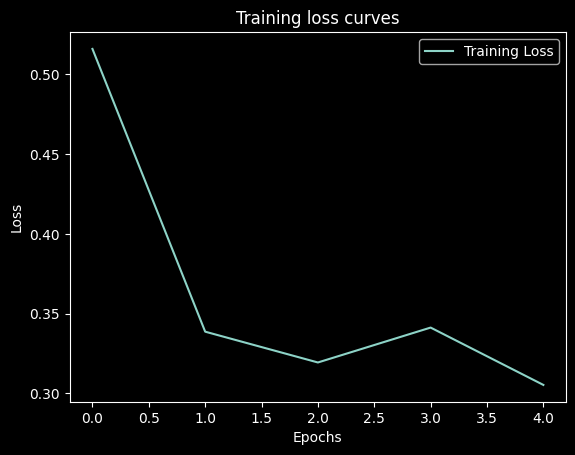

In [ ]:
# Plotting the training and validation losses
# plt.plot(epoch_count, torch.tensor(train_loss_values), label="Train loss")
plt.plot(epoch_count, train_losses, label='Training Loss')
plt.title("Training loss curves")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [ ]:
## Cosine Similarity Score of answer from whole string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_cosine_similarity(prediction, actual):
  start_token = "<s_class>"
  end_token = "</s_class>"

  # Extract the <s_answer> and </s_answer> substrings
  prediction_answer = prediction[prediction.index(start_token) + len(start_token):prediction.index(end_token)]
  actual_answer = actual[actual.index(start_token) + len(start_token):actual.index(end_token)]

  # Vectorize the extracted answers
  vectorizer = TfidfVectorizer()
  tfidf_matrix = vectorizer.fit_transform([prediction_answer, actual_answer])

  # Calculate cosine similarity
  similarity_score = cosine_similarity(tfidf_matrix[0], tfidf_matrix[1])[0][0]
  return similarity_score


In [ ]:
def slicingPrompt(gtPrompt):

  start_index = gtPrompt.index("<s_class>")  # Find the index of the start tag "<s_class>"
  end_index = gtPrompt.index("</s_class>") + len("</s_class>")  # Find the index of the end tag "</s_class>" and add its length

  sliced_prompt = gtPrompt[start_index:end_index]  # Slice the desired part using the start and end indices

  return sliced_prompt


In [ ]:
config = {
    "verbose": True
}

In [ ]:
model.eval()
accs = []
with torch.no_grad():
  ## For validation dataset
  for pixel_values, gt_prompt in tqdm(valid_dataloader):
    pixel_values = pixel_values.to(device)
    gt_prompt = slicingPrompt(gt_prompt[0])

    # prepare decoder inputs for Doc Classification task
    task_start_prompt = "<s_docClass>"
    decoder_start_input_ids = processor.tokenizer(task_start_prompt, add_special_tokens=False, return_tensors="pt").input_ids
    decoder_start_input_ids = decoder_start_input_ids.to(device)

    outputs_gen = model.generate(pixel_values,
                                decoder_input_ids = decoder_start_input_ids,
                                max_length=max_length,
                                early_stopping=True,
                                pad_token_id=processor.tokenizer.pad_token_id,
                                eos_token_id=processor.tokenizer.eos_token_id,
                                use_cache=True,
                                num_beams=1,
                                bad_words_ids=[[processor.tokenizer.unk_token_id]],
                                return_dict_in_generate=True,
                                )
    # print(outputs_gen.sequences)
    # Process and evaluate the predictions and answers
    # predictions = []
    scores = []

    for seq in processor.tokenizer.batch_decode(outputs_gen.sequences):
      # print(seq)
      seq = seq.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
      pred_prompt = re.sub(r"<.*?>", "", seq, count=1).strip()
      # print(seq, type(seq))
      # predictions.append(seq)
    # print(predictions)
      actual_prompt = gt_prompt
      similarity_score = calculate_cosine_similarity(pred_prompt, actual_prompt)
      scores.append(similarity_score)
      accs.append(scores[0])

      if config.get("verbose", False) and len(scores) == 1:
        print(f"Predicted Class: {pred_prompt}")
        print(f"Actual Class: {actual_prompt}")
        print(f"Normed Similarity Score: {scores[0]}")


    print('*************************************************')

  # print(accs)
  print(f"Mean Validation Accuracy Score after Epoch {epoch + 1} is: {np.mean(accs)}")
  print('+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')



  0%|          | 0/800 [00:00<?, ?it/s]

Predicted Class: <s_class><memo/></s_class>
Actual Class: <s_class><memo/></s_class>
Normed Similarity Score: 1.0
*************************************************
Predicted Class: <s_class><memo/></s_class>
Actual Class: <s_class><memo/></s_class>
Normed Similarity Score: 1.0
*************************************************
Predicted Class: <s_class><memo/></s_class>
Actual Class: <s_class><memo/></s_class>
Normed Similarity Score: 1.0
*************************************************
Predicted Class: <s_class><memo/></s_class>
Actual Class: <s_class><memo/></s_class>
Normed Similarity Score: 1.0
*************************************************
Predicted Class: <s_class><memo/></s_class>
Actual Class: <s_class><memo/></s_class>
Normed Similarity Score: 1.0
*************************************************
Predicted Class: <s_class><memo/></s_class>
Actual Class: <s_class><memo/></s_class>
Normed Similarity Score: 1.0
*************************************************
Predicted Class:

## Save, Reload, Push model from HF Hub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## Save processor in drive
processor.save_pretrained("/content/drive/MyDrive/Model_Processor_HF/donut_rvlcdip_m")

In [ ]:
## Push model to Hub
model.push_to_hub("indra-inc/donut_rvlcdip_m_finetune_doc_classification")

pytorch_model.bin:   0%|          | 0.00/809M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/indra-inc/donut_rvlcdip_m_finetune_doc_classification/commit/28300c41cbc6b639c8a59275eafc59b0ff4db648', commit_message='Upload model', commit_description='', oid='28300c41cbc6b639c8a59275eafc59b0ff4db648', pr_url=None, pr_revision=None, pr_num=None)

## Reloading the model from hub

In [ ]:
model_checkpoint_loaded = "indra-inc/donut_rvlcdip_m_finetune_doc_classification"

## Loading the saved processor
loaded_processor = DonutProcessor.from_pretrained(model_checkpoint_loaded)
loaded_model = VisionEncoderDecoderModel.from_pretrained(model_checkpoint_loaded)

## S: Inference Check

In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Move the model to the device
# loaded_model = loaded_model.to(device)

# ## Test Inference custom function for Document Classification
# def run_prediction(user_test_sample, model=loaded_model, processor=loaded_processor):

#   user_test_image = Image.open(user_test_sample).convert("RGB")
#   # display(user_test_image)

#   pixel_values = processor(user_test_image, return_tensors="pt").pixel_values
#   # print(pixel_values.shape)
#   pixel_values = pixel_values.to(device)

#   inf_start_prompt = "<s_docClass>"
#   decoder_start_input_ids_inf = processor.tokenizer(inf_start_prompt, add_special_tokens=False, return_tensors="pt").input_ids
#   decoder_start_input_ids_inf = decoder_start_input_ids_inf.to(device)

#   test_outputs = model.generate(pixel_values,
#                                decoder_input_ids = decoder_start_input_ids_inf,
#                                max_length = model.decoder.config.max_position_embeddings,
#                                early_stopping = True,
#                                pad_token_id = processor.tokenizer.pad_token_id,
#                                eos_token_id = processor.tokenizer.eos_token_id,
#                                use_cache = True,
#                                num_beams = 1,
#                                bad_words_ids = [[processor.tokenizer.unk_token_id]],
#                                return_dict_in_generate = True,
#                                output_scores = True)

#   test_seq_prediction = processor.batch_decode(test_outputs.sequences)[0]
#   test_seq_prediction = test_seq_prediction.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
#   test_seq_prediction = re.sub(r"<.*?>", "", test_seq_prediction, count=1).strip()  # remove first task start token
#   print(test_seq_prediction)

#   test_seq_prediction_json = processor.token2json(test_seq_prediction)

#   return test_seq_prediction_json

In [ ]:
## User image path
# test_img = '/content/em1.tif'

In [ ]:
# user_json_result = run_prediction(test_img)
# user_json_result